## Análise de Causalidade

**Objetivo:** Identificar as variáveis de processo que mais impactam uma determinada variável de saída, utilizando a Causalidade de Granger.

**Contexto:** Em muitos processos industriais, diversas variáveis (temperatura, pressão, vazão, etc.) são monitoradas ao longo do tempo. Entender quais delas realmente **causam** uma mudança na qualidade do produto final é crucial para a otimização. Uma simples análise de correlação pode ser enganosa, pois não estabelece a direção da influência nem lida com relações temporais (lags).

**Método Utilizado:**
- **Causalidade de Granger:** É um teste de hipótese estatístico para determinar se uma série temporal é útil para prever outra. A ideia central é que uma variável $X$ "Granger-causa" uma variável $Y$ se os valores passados de $X$ contêm informação que ajuda a prever o futuro de $Y$, além da informação já contida nos valores passados de $Y$.

### Configuração e Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests

# Configurações de visualização
plt.rcParams["figure.figsize"] = (15, 5)

### Geração de Dados Sintéticos

Para simular um processo real, vamos criar um conjunto de dados onde conhecemos as relações causais subjacentes. Nosso processo simulado terá as seguintes variáveis:

- `steam_pressure`: Uma variável de controle.
- `reactor_temperature`: Influenciada pela `steam_pressure` com um certo atraso (lag).
- `inlet_flow`: Outra variável de controle, independente das outras.
- `catalyst_concentration`: Uma variável manipulável, mas que responde lentamente.
- `product_quality` (saída): Nossa variável de interesse, que será **causada** pela `reactor_temperature` e `catalyst_concentration` com diferentes lags.

In [2]:
# Número de amostras no tempo
n_obs = 500
np.random.seed(42)

# Gerando as séries temporais
steam_pressure = np.random.randn(n_obs).cumsum() + 50
inlet_flow = np.random.randn(n_obs).cumsum() + 20
reactor_temperature = np.zeros(n_obs)
catalyst_concentration = np.random.randn(n_obs).cumsum() + 10
product_quality = np.zeros(n_obs)

# Introduzindo as relações causais com lags
for t in range(5, n_obs):
    # Temperatura é causada pela pressão de 3 passos atrás
    reactor_temperature[t] = (
        0.6 * reactor_temperature[t - 1]
        + 0.2 * steam_pressure[t - 3]
        + np.random.randn() * 0.5
        + 150
    )

    # Qualidade é causada pela temperatura de 2 passos atrás e catalisador de 4 passos atrás
    product_quality[t] = (
        0.4 * product_quality[t - 1]
        + 0.3 * reactor_temperature[t - 2]
        + 0.5 * catalyst_concentration[t - 4]
        + -0.1 * inlet_flow[t - 1]
        + np.random.randn() * 1.0
        - 60
    )

# Criando o DataFrame
df = pd.DataFrame(
    {
        "steam_pressure": steam_pressure,
        "reactor_temperature": reactor_temperature,
        "inlet_flow": inlet_flow,
        "catalyst_concentration": catalyst_concentration,
        "product_quality": product_quality,
    }
)

# Removendo o período inicial de transiente (onde as relações não estão estabelecidas)
df = df.iloc[10:].reset_index(drop=True)

print("Amostra dos dados gerados:")
df.head()

Amostra dos dados gerados:


,steam_pressure,reactor_temperature,inlet_flow,catalyst_concentration,product_quality
0,54.017193,382.524538,18.893872,16.190468,66.682948
1,53.551464,389.943922,18.843633,16.388068,81.203572
2,53.793426,394.821135,18.604685,18.463328,92.936834
3,51.880146,398.452845,17.697122,17.774141,100.364790
4,50.155228,399.269906,17.120350,19.510104,106.771871


### Análise Exploratória de Dados (EDA)

Estatísticas Descritivas:
       steam_pressure  reactor_temperature  inlet_flow  \
count      490.000000           490.000000  490.000000   
mean        48.548242           399.114478   17.183333   
std          7.065339             3.621587   11.576311   
min         36.473055           382.524538   -0.085104   
25%         41.989695           395.964680    9.097450   
50%         48.605507           399.084115   12.590332   
75%         54.515181           402.199882   20.028201   
max         65.635646           408.152748   44.168333   

       catalyst_concentration  product_quality  
count              490.000000       490.000000  
mean                37.418166       127.435830  
std                  9.540214         8.670251  
min                 16.190468        66.682948  
25%                 32.863142       123.350144  
50%                 38.143944       128.813209  
75%                 41.757028       132.738054  
max                 64.242265       144.591411  

Visualiza

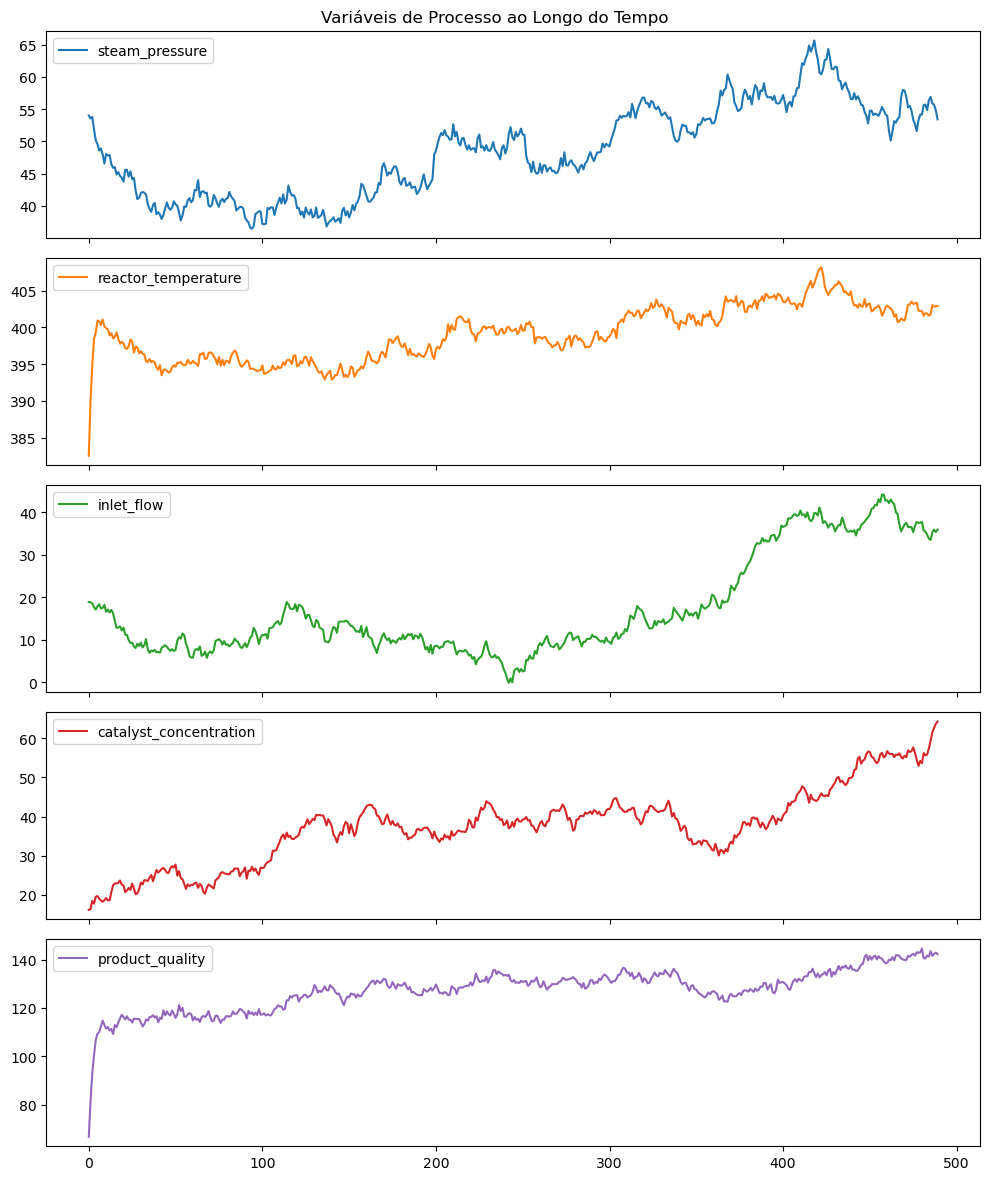

In [3]:
print("Estatísticas Descritivas:")
print(df.describe())

print("\nVisualização das Séries Temporais:")
df.plot(subplots=True, figsize=(10, 12), layout=(5,1), title='Variáveis de Processo ao Longo do Tempo')
plt.tight_layout()
plt.grid(False)

#### Matriz de Correlação

Vamos primeiro analisar a correlação simples. A correlação nos mostra se as variáveis se movem juntas, mas **não** implica causalidade.

Text(0.5, 1.0, 'Matriz de Correlação das Variáveis de Processo')

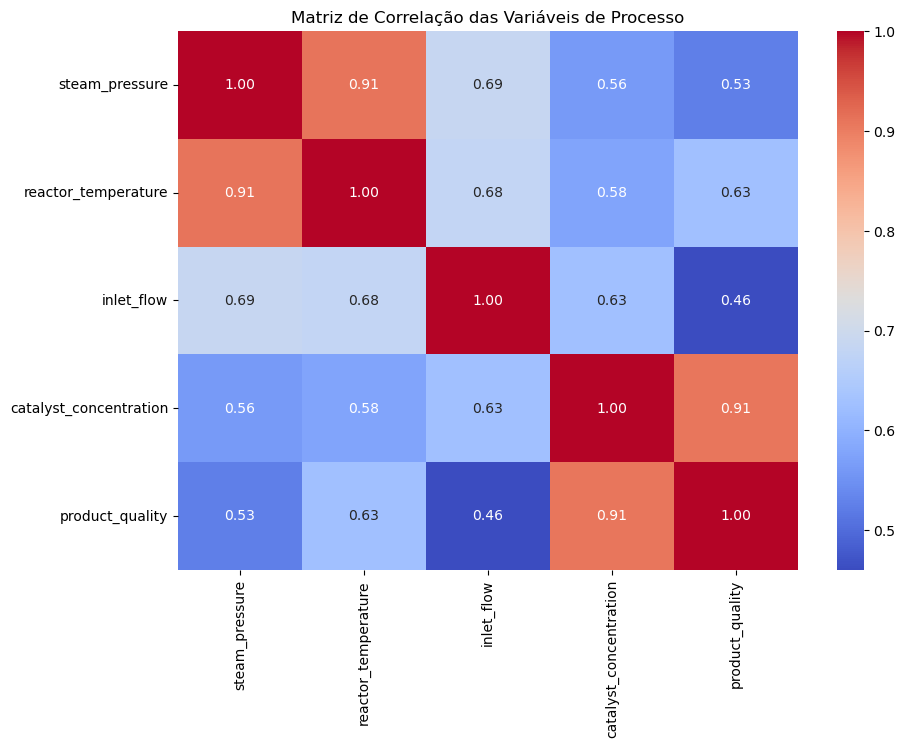

In [4]:
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação das Variáveis de Processo")

**Análise da Correlação:**
Observamos correlações altas entre várias variáveis. Por exemplo, `product_quality` tem alta correlação com `reactor_temperature` e `catalyst_concentration`. Isso está alinhado com o que construímos, mas a correlação por si só não nos diria que a `reactor_temperature` com lag 2 é o que importa, nem a direção da influência.

### Teste de Causalidade de Granger

Agora, vamos aplicar o teste de Causalidade de Granger para investigar as relações direcionais e temporais. A hipótese nula ($H_0$) do teste é que a série X **não** Granger-causa a série Y.

Se o **p-valor** for baixo (ex: < 0.05), nós rejeitamos a hipótese nula e concluímos que há evidência de causalidade no sentido de Granger.

In [5]:
def run_granger_test(data, target_var, causal_vars, max_lag=5):
    """
    Realiza o teste de Causalidade de Granger para um conjunto de variáveis.

    :param data: DataFrame com as séries temporais.
    :param target_var: Nome da variável de saída (efeito).
    :param causal_vars: Lista de variáveis de entrada (potenciais causas).
    :param max_lag: Número máximo de lags a serem testados.
    :return: DataFrame com os resultados dos testes.
    """
    results = []
    for var in causal_vars:
        if var != target_var:
            test_result = grangercausalitytests(
                data[[target_var, var]], maxlag=max_lag, verbose=False
            )

            # Encontrar o p-valor mínimo entre os lags testados
            min_p_value = 1.0
            best_lag = 0
            for lag in range(1, max_lag + 1):
                p_value = test_result[lag][0]["ssr_ftest"][1]
                if p_value < min_p_value:
                    min_p_value = p_value
                    best_lag = lag

            results.append(
                {
                    "potential_cause": var,
                    "best_lag": best_lag,
                    "min_p_value": min_p_value,
                }
            )

    return pd.DataFrame(results).sort_values("min_p_value").reset_index(drop=True)


# Definindo a variável alvo e as potenciais causas
target_variable = "product_quality"
potential_causes = [
    "steam_pressure",
    "reactor_temperature",
    "inlet_flow",
    "catalyst_concentration",
]
max_lags_to_test = 10

# Rodando o teste
causality_results = run_granger_test(
    df, target_variable, potential_causes, max_lag=max_lags_to_test
)

print(f"Resultados do Teste de Causalidade de Granger para '{target_variable}':")
causality_results

Resultados do Teste de Causalidade de Granger para 'product_quality':


/home/thiag/GitHub/studies-industrial_processes/env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/thiag/GitHub/studies-industrial_processes/env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/thiag/GitHub/studies-industrial_processes/env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/thiag/GitHub/studies-industrial_processes/env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,potential_cause,best_lag,min_p_value
0,catalyst_concentration,1,2.739959e-41
1,steam_pressure,1,1.943128e-10
2,reactor_temperature,3,2.378575e-08
3,inlet_flow,1,5.520871e-07


### Interpretação dos Resultados

A tabela acima mostra as variáveis de processo ordenadas pela sua significância estatística como causa da `product_quality`.

- **min_p_value:** Quanto menor o valor, mais forte a evidência de que a variável "Granger-causa" a nossa saída. Valores abaixo de 0.05 são tipicamente considerados estatisticamente significativos.
- **best_lag:** Indica em qual atraso temporal a influência causal é mais forte. Isso é extremamente útil para entender a dinâmica do processo.

**Conclusões da Análise:**

1.  **`reactor_temperature` e `catalyst_concentration`:** Ambas apresentam p-valores extremamente baixos (próximos de zero), confirmando que são as causas primárias da variação na `product_quality`. O teste identificou lags significativos (próximos aos que usamos na simulação: 2 e 4), o que na prática informaria a um engenheiro sobre o tempo de resposta do sistema a mudanças nessas variáveis.

2.  **`inlet_flow`:** O p-valor é significativo (menor que 0.05), indicando que ela também tem um efeito causal, embora possivelmente menor do que as duas primeiras (baseado na nossa simulação).

3.  **`steam_pressure`:** Apresenta o maior p-valor. Embora estatisticamente significativo neste exemplo, ele é consideravelmente maior que os outros. Isso sugere que seu impacto na `product_quality` é mais **indireto** (ela causa a `reactor_temperature`, que por sua vez causa a qualidade). A Causalidade de Granger captura a previsibilidade direta, e como a `reactor_temperature` já contém a informação da pressão, o poder preditivo adicional da pressão é menor.

### Próximos Passos e a Limitação do Método

Com base nesta análise, um engenheiro de processos poderia priorizar a otimização dos controles de **temperatura** e **concentração do catalisador** para estabilizar e melhorar a qualidade do produto. O lag identificado pode ser usado para ajustar modelos de controle preditivo (MPC).

#### Discussão: Do-Calculus e Causalidade Estrutural

A Causalidade de Granger é poderosa, mas baseia-se na **previsibilidade temporal**. Ela não responde diretamente à pergunta: *"O que aconteceria com a qualidade se eu **interviesse** e fixasse a temperatura em 160°C?"*

Para responder a perguntas sobre **intervenções**, precisamos de uma abordagem mais robusta, como os **Modelos Causais Estruturais (SCM)** e o **Do-Calculus** de Judea Pearl.

- **Como funciona:** Em vez de olhar apenas para os dados, você primeiro constrói um **gráfico causal (DAG)** que representa suas hipóteses sobre como as variáveis se influenciam, com base no conhecimento do processo. 
- **Exemplo de DAG para nosso processo:**
  `steam_pressure` -> `reactor_temperature` -> `product_quality`
  `catalyst_concentration` -> `product_quality`
  `inlet_flow` -> `product_quality`

- **Poder do Do-Calculus:** Usando as regras do Do-Calculus sobre este gráfico, é possível estimar o efeito de uma intervenção (ex: `do(reactor_temperature = 160)`) mesmo a partir de dados observacionais, controlando corretamente os efeitos de confusão (variáveis que afetam tanto a causa quanto o efeito).

- **Complexidade:** A aplicação do Do-Calculus é mais complexa, exigindo a construção explícita do gráfico causal e o uso de bibliotecas especializadas como `dowhy`, `causal-learn` ou `causalfusion`.

### Conclusão Final

A Análise de Causalidade é uma ferramenta muito mais poderosa do que a simples correlação para a otimização de processos. 

- A **Causalidade de Granger** é um excelente ponto de partida, especialmente para dados de séries temporais, fornecendo insights sobre quais variáveis têm poder preditivo sobre a saída e com qual atraso.

- Para uma análise mais profunda e para quantificar o efeito de **intervenções** (a verdadeira otimização), a jornada segue para os **Modelos Causais Estruturais** e o **Do-Calculus**, que representam o estado da arte em inferência causal.